In [1]:
import re, pandas as pd, seaborn as sns
from glob import glob
from os import path
from matplotlib.pyplot import subplots, style, rc
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

style.use(["seaborn-v0_8-poster", "seaborn-v0_8-whitegrid"])
rc("figure", figsize=(12, 5), dpi=150)
rc("axes", linewidth=1, edgecolor="black")
rc("legend", fontsize=15)
%matplotlib inline

### Calculate all baseline counts of 5-, 6-, and 7-mers:

```bash
for k in $(seq 5 7); do
    jellyfish count -t12 -s 4G -L0 -m 5 -o "reads/${SAMPLE}-k${k}.db" <(zcat "reads/${SAMPLE}.fastq.gz")
    jellyfish dump -c -t -L 0 -o "counts-baseline/${SAMPLE}-k${k}.tsv" "reads/${SAMPLE}-k${k}.db"
done
```

In [2]:
# All following code assumes that ${SAMPLE} is of form "subject-timepoint", e.g. "C001-4":

def prettify_inplace(df):
    df.columns = pd.MultiIndex.from_tuples(c.split("/") for c in list(df.columns))
    df.columns.names = ["timepoint", "subject"]
    return df.astype(int)

totals = pd.DataFrame()

for tsv in sorted(glob("counts-baseline/*-k?.tsv")):
    subject, timepoint, k = re.search(r'(.*)-(.*)-k(\d)', path.split(tsv)[-1]).groups()
    totals.loc[int(k), f"{timepoint}/{subject}"] = pd.read_csv(tsv, sep="\t", usecols=(1,), names=["count"])["count"].sum()

totals = prettify_inplace(totals)
totals

timepoint,1,2,3,4,5,6,1,2,3,4,...,3,4,5,6,1,2,3,4,5,6
subject,C001,C001,C001,C001,C001,C001,C002,C002,C002,C002,...,C003,C003,C003,C003,C004,C004,C004,C004,C004,C004
5,70240091057,40898987143,31064886684,22880632056,31065092889,26827299929,90400101770,29945216944,31252878917,23581741182,...,32244867667,29842284332,31094817905,37382508916,67789170540,44103378827,29843871704,32179110775,31684983602,24991253188
6,68962511649,40155084259,30499855631,22464461451,30499555023,26338911818,88755835836,29400551894,30684427773,23152819688,...,31658372387,29299490301,30528737615,36701966308,66556170160,43301211067,29301049800,31593812700,31108163086,24536290296
7,67684933525,39411182154,29934825182,22048291252,29934033570,25850538028,87111571627,28855887406,30115977213,22723898583,...,31071877703,28756696820,29962673943,36021443652,65323170965,42499044077,28758228423,31008515243,30531359256,24081340689


### Filter for UUAGGG and its reverse complement:

(Note that FASTQ files still contain it in a DNA-like alphabet, we'll deal with it later)

```bash
zcat "reads/${SAMPLE}.fastq.gz" \
    | bioawk -c fastx '{print $seq}' \
    | grep -iE 'ttaggg|ccctaa' \
    | nl \
    | sed -E 's/^\s+/>/g; s/\s+/\n/g' \
    | gzip -3 \
    > "reads-filtered/${SAMPLE}.fasta.gz"
```

### Calculate counts of 5-, 6-, and 7-mers in the filtered reads:

```bash
for k in $(seq 5 7); do
    jellyfish count -t12 -s 4G -C -L0 -m 5 -o "reads-filtered/${SAMPLE}-k${k}.db" \
        <(zcat "reads-filtered/${SAMPLE}.fasta.gz")
    jellyfish dump -c -t -L 0 -o "counts-filtered/${SAMPLE}-k${k}.tsv" "reads-filtered/${SAMPLE}-k${k}.db"
done
```

In [3]:
data = pd.concat(axis=1, objs=[
    pd.concat([
        pd.read_csv(
            f"counts-filtered/{subject}-{timepoint}-k{k}.tsv",
            sep="\t", index_col=0, names=[f"{timepoint}/{subject}"],
        )
        for k in (5, 6, 7)
    ])
    for timepoint, subject in totals.columns
])

data = prettify_inplace(data)
data

timepoint,1,2,3,4,5,6,1,2,3,4,...,3,4,5,6,1,2,3,4,5,6
subject,C001,C001,C001,C001,C001,C001,C002,C002,C002,C002,...,C003,C003,C003,C003,C004,C004,C004,C004,C004,C004
AAAAA,13273282,9667284,5991250,5148190,5692065,5894051,17831031,6632802,5894196,4428918,...,7678179,5458611,6038555,8771562,13490011,10151229,7511461,6265386,6861599,5206920
AAAAC,6006792,3511662,3206363,2241991,2125795,2239056,7986740,2572754,3129039,2153469,...,3315526,2699332,2297396,3147127,6098573,3821484,2795357,2981861,2706690,2154693
AAAAG,5746219,3909721,1271684,1794489,2042773,2339020,7524695,2913590,1257567,1811249,...,1461512,2186469,2020628,3308301,5429322,4218417,1462616,2425607,2203507,2151597
AAAAT,8053854,5640834,3109544,2961265,2925727,3429081,10282933,4015572,2475451,2547546,...,3426284,3117133,2892975,4756280,7661937,5937681,2973752,3588906,3457914,3022481
AAACA,5881617,3730309,2880397,2059744,2325614,2325894,7500012,2745916,2604648,1994566,...,2884094,2668842,2460122,3264340,5534846,4014305,2362951,2742423,2683901,2220662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGCCAA,214364,109606,167834,76471,86767,75211,244510,77256,114549,69301,...,159419,112521,96450,101028,217234,119530,142432,117965,117341,124755
TTGGAAA,303514,225169,11609,79251,165332,106904,398168,158227,18843,86431,...,13743,108711,145796,148346,274882,234810,28810,120280,112768,87378
TTGTAAA,236785,166238,46620,74515,82364,91825,305864,121558,40733,74583,...,35525,90092,78763,127526,232888,179592,42312,97419,90004,75576


### Normalize these counts by totals, per value of k:

In [4]:
data = pd.concat(axis=0, objs=[
    data[data.index.map(len)==k] / totals.loc[k]
    for k in totals.index
])

data

timepoint,1,2,3,4,5,6,1,2,3,4,...,3,4,5,6,1,2,3,4,5,6
subject,C001,C001,C001,C001,C001,C001,C002,C002,C002,C002,...,C003,C003,C003,C003,C004,C004,C004,C004,C004,C004
AAAAA,0.000189,0.000236,1.928624e-04,0.000225,0.000183,0.000220,0.000197,0.000221,1.885969e-04,0.000188,...,2.381210e-04,0.000183,0.000194,0.000235,0.000199,0.000230,0.000252,0.000195,0.000217,0.000208
AAAAC,0.000086,0.000086,1.032150e-04,0.000098,0.000068,0.000083,0.000088,0.000086,1.001200e-04,0.000091,...,1.028234e-04,0.000090,0.000074,0.000084,0.000090,0.000087,0.000094,0.000093,0.000085,0.000086
AAAAG,0.000082,0.000096,4.093638e-05,0.000078,0.000066,0.000087,0.000083,0.000097,4.023844e-05,0.000077,...,4.532541e-05,0.000073,0.000065,0.000088,0.000080,0.000096,0.000049,0.000075,0.000070,0.000086
AAAAT,0.000115,0.000138,1.000984e-04,0.000129,0.000094,0.000128,0.000114,0.000134,7.920714e-05,0.000108,...,1.062583e-04,0.000104,0.000093,0.000127,0.000113,0.000135,0.000100,0.000112,0.000109,0.000121
AAACA,0.000084,0.000091,9.272195e-05,0.000090,0.000075,0.000087,0.000083,0.000092,8.334106e-05,0.000085,...,8.944351e-05,0.000089,0.000079,0.000087,0.000082,0.000091,0.000079,0.000085,0.000085,0.000089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGCCAA,0.000003,0.000003,5.606647e-06,0.000003,0.000003,0.000003,0.000003,0.000003,3.803596e-06,0.000003,...,5.130652e-06,0.000004,0.000003,0.000003,0.000003,0.000003,0.000005,0.000004,0.000004,0.000005
TTGGAAA,0.000004,0.000006,3.878092e-07,0.000004,0.000006,0.000004,0.000005,0.000005,6.256812e-07,0.000004,...,4.422971e-07,0.000004,0.000005,0.000004,0.000004,0.000006,0.000001,0.000004,0.000004,0.000004
TTGTAAA,0.000003,0.000004,1.557383e-06,0.000003,0.000003,0.000004,0.000004,0.000004,1.352538e-06,0.000003,...,1.143317e-06,0.000003,0.000003,0.000004,0.000004,0.000004,0.000001,0.000003,0.000003,0.000003


### Convert kmers to their alphabetically lowest inversion (ALI) and collapse counts:

In [5]:
ali = lambda kmer: min(kmer[i:]+kmer[:i] for i in range(len(kmer)))
data.index = data.index.map(ali)
data = data.groupby(data.index).sum()
data

timepoint,1,2,3,4,5,6,1,2,3,4,...,3,4,5,6,1,2,3,4,5,6
subject,C001,C001,C001,C001,C001,C001,C002,C002,C002,C002,...,C003,C003,C003,C003,C004,C004,C004,C004,C004,C004
AAAAA,1.889702e-04,2.363698e-04,1.928624e-04,2.250021e-04,1.832303e-04,2.197035e-04,1.972457e-04,2.214979e-04,1.885969e-04,1.878113e-04,...,2.381210e-04,1.829153e-04,1.941981e-04,2.346435e-04,1.989995e-04,2.301690e-04,2.516919e-04,1.947035e-04,2.165568e-04,2.083497e-04
AAAAAA,9.260504e-05,1.228208e-04,9.324113e-05,1.094407e-04,9.719568e-05,1.108014e-04,1.020954e-04,1.124030e-04,1.086140e-04,9.512461e-05,...,1.277553e-04,9.287738e-05,1.079488e-04,1.245955e-04,1.022663e-04,1.199178e-04,1.506570e-04,9.846567e-05,1.156849e-04,1.030573e-04
AAAAAAA,6.003671e-05,8.283796e-05,7.258449e-05,7.690873e-05,7.150613e-05,7.596360e-05,6.809907e-05,7.289694e-05,8.863079e-05,6.358865e-05,...,1.054996e-04,6.221820e-05,8.025712e-05,8.876507e-05,6.937681e-05,8.022936e-05,1.292696e-04,6.764261e-05,8.496736e-05,7.053424e-05
AAAAAAC,8.607891e-05,8.843036e-05,1.458261e-04,1.185490e-04,7.858029e-05,9.330111e-05,8.652224e-05,8.717320e-05,1.277134e-04,9.970917e-05,...,1.399611e-04,9.692494e-05,8.539642e-05,9.394510e-05,9.032310e-05,8.728392e-05,1.282252e-04,9.985918e-05,1.021809e-04,1.074357e-04
AAAAAAG,7.400526e-05,9.484171e-05,1.014878e-05,6.462201e-05,5.429589e-05,7.886114e-05,7.697227e-05,9.558722e-05,1.456051e-05,6.737039e-05,...,1.319769e-05,6.312585e-05,5.509391e-05,7.918464e-05,7.196858e-05,9.533857e-05,2.431499e-05,6.565667e-05,5.930276e-05,7.110671e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCTTTGT,2.087983e-06,2.485107e-06,4.880269e-07,1.899558e-06,1.679226e-06,2.315503e-06,2.413066e-06,2.566478e-06,5.171009e-07,1.953230e-06,...,4.799839e-07,1.850039e-06,1.574859e-06,2.499428e-06,2.120702e-06,2.531375e-06,7.246274e-07,1.995968e-06,1.880362e-06,2.303402e-06
CCTTTT,1.903114e-05,2.121116e-05,1.811438e-05,2.126532e-05,1.731311e-05,2.112475e-05,1.852767e-05,2.164487e-05,1.547876e-05,1.927441e-05,...,1.687051e-05,1.862196e-05,1.709963e-05,2.065794e-05,1.841895e-05,2.148566e-05,1.872469e-05,1.921205e-05,1.905477e-05,2.390182e-05
CCTTTTG,2.893037e-06,3.250423e-06,2.167041e-07,2.266343e-06,3.523514e-06,2.778782e-06,3.031870e-06,3.583705e-06,3.450992e-07,2.619181e-06,...,2.116705e-07,2.501365e-06,3.164270e-06,2.674074e-06,2.733410e-06,3.593893e-06,6.184317e-07,2.489606e-06,2.258432e-06,2.332677e-06


### Convert to ACGU, switch to "nicer-looking" inversions wrt reverse complementarity, rename columns:

In [6]:
ALPHABET = list("ACGT")
COMPLEMENTS = dict(zip(ALPHABET, reversed(ALPHABET)))
COMPLEMENT_PATTERN = re.compile(r'|'.join(COMPLEMENTS.keys()))
revcomp = lambda kmer: COMPLEMENT_PATTERN.sub(lambda match: COMPLEMENTS[match.group()], kmer[::-1])

def canonicalize(kmer):
    """ This picks a human-friendly inversion between the forward and the reverse variant,
        e.g. "AGGGTT" -> "TTAGGG" -> "UUAGGG"
        but also e.g. "ACCCTA" -> "TAGGGT" -> "TTAGGG" -> "UUAGGG" because the reverse complement "wins"
    """
    rckmer, tloc = max(kmer, revcomp(kmer)), -1
    for pat in "TT", "T", "CC", "C":
        if (tloc := rckmer.find(pat)) >= 0:
            break
    return ((rckmer[tloc:]+rckmer[:tloc]) if (tloc > 0) else rckmer).replace("T", "U")

data.index = data.index.map(canonicalize)

# Since forward and reverse kmers are now renamed to the same thing, collapse their counts again:
data = data.groupby(data.index).sum()
data.index.name = "kmer"

data

timepoint,1,2,3,4,5,6,1,2,3,4,...,3,4,5,6,1,2,3,4,5,6
subject,C001,C001,C001,C001,C001,C001,C002,C002,C002,C002,...,C003,C003,C003,C003,C004,C004,C004,C004,C004,C004
kmer,,,,,,,,,,,,,,,,,,,,,
CCAGGCG,0.000002,9.563276e-07,4.296234e-06,0.000002,0.000001,0.000001,0.000002,0.000001,4.509334e-06,0.000002,...,3.815025e-06,0.000002,0.000001,0.000001,0.000002,9.790338e-07,3.473754e-06,0.000003,0.000002,0.000001
CCCGGCG,0.000001,1.716264e-06,4.742303e-07,0.000001,0.000001,0.000002,0.000001,0.000002,7.423634e-07,0.000001,...,4.739334e-07,0.000001,0.000001,0.000002,0.000001,1.844818e-06,8.406290e-07,0.000001,0.000002,0.000002
CCCGGG,0.000020,1.919047e-05,4.889915e-05,0.000036,0.000037,0.000025,0.000018,0.000017,3.868930e-05,0.000019,...,7.079710e-05,0.000022,0.000037,0.000027,0.000023,1.849424e-05,5.651057e-05,0.000025,0.000037,0.000023
CCCGGGG,0.000011,1.081178e-05,2.563142e-05,0.000019,0.000022,0.000014,0.000011,0.000010,2.064007e-05,0.000011,...,3.678407e-05,0.000012,0.000021,0.000014,0.000013,1.053904e-05,3.002678e-05,0.000013,0.000019,0.000012
CCGAGGG,0.000009,8.012548e-06,5.674662e-07,0.000006,0.000012,0.000007,0.000008,0.000009,1.114990e-06,0.000006,...,6.660042e-07,0.000006,0.000012,0.000007,0.000009,9.532309e-06,1.843403e-06,0.000006,0.000009,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UUUUUU,0.000093,1.228208e-04,9.324113e-05,0.000109,0.000097,0.000111,0.000102,0.000112,1.086140e-04,0.000095,...,1.277553e-04,0.000093,0.000108,0.000125,0.000102,1.199178e-04,1.506570e-04,0.000098,0.000116,0.000103
UUUUUUA,0.000090,1.113137e-04,4.974601e-05,0.000085,0.000064,0.000095,0.000092,0.000108,4.085768e-05,0.000082,...,4.300471e-05,0.000079,0.000068,0.000095,0.000088,1.097625e-04,4.374967e-05,0.000081,0.000076,0.000084


### Just sorting and presentation stuff:

The next block contains no data transformations, we just rename timepoints to what they're referred to as in the paper,
and sort rows by mean _k_-mer count descending:

In [7]:
DISP = ["L-92", "L-44", "L-3", "R+1", "R+45", "R+82"]

data = data.reindex(data[["1", "2", "4", "5", "6"]].mean(axis=1).sort_values()[::-1].index)
data = data[[str(x) for x in (1, 2, 4, 5, 6)]].copy()
_names = data.columns.names
data.columns = pd.MultiIndex.from_tuples([(DISP[int(a)-1], b) for a, b in data.columns])
data.columns.names = _names

data

timepoint          L-92                                            \
subject            C001          C002          C003          C004   
kmer                                                                
UUAGGG     5.840946e-04  5.844780e-04  5.602267e-04  5.508011e-04   
UAGGG      5.705269e-04  5.833224e-04  5.804847e-04  5.654779e-04   
UUAGG      5.742699e-04  5.624908e-04  5.670012e-04  5.680698e-04   
UUUUA      4.940295e-04  5.067503e-04  5.406812e-04  4.991041e-04   
UUUAA      4.494490e-04  4.616336e-04  5.154653e-04  4.787326e-04   
...                 ...           ...           ...           ...   
UCGUAGG    2.085841e-07  2.351582e-07  1.968626e-07  1.720829e-07   
UCGCUAG    1.584252e-07  1.666024e-07  1.418180e-07  1.283312e-07   
UCGACCA    1.594890e-07  1.888153e-07  1.530983e-07  1.371489e-07   
UCGACGA    1.045580e-07  9.306456e-08  8.162884e-08  8.897302e-08   
UCCGCGA    1.003030e-07  9.867805e-08  8.481470e-08  8.217605e-08   

timepoint          L-44                                            \
subject            C001          C002          C003          C004   
kmer                                                                
UUAGGG     5.482191e-04  5.633751e-04  5.798850e-04  5.807955e-04   
UAGGG      5.432515e-04  5.494154e-04  5.748440e-04  5.676775e-04   
UUAGG      5.458982e-04  5.506034e-04  5.695656e-04  5.651088e-04   
UUUUA      5.701513e-04  5.549330e-04  5.806680e-04  5.660922e-04   
UUUAA      4.803327e-04  4.699853e-04  4.936900e-04  4.812267e-04   
...                 ...           ...           ...           ...   
UCGUAGG    1.988776e-07  1.913994e-07  1.844536e-07  2.090871e-07   
UCGCUAG    1.825117e-07  1.916073e-07  1.529455e-07  2.166166e-07   
UCGACCA    1.662219e-07  1.833248e-07  1.683245e-07  1.782393e-07   
UCGACGA    9.489693e-08  1.177229e-07  9.801736e-08  1.094142e-07   
UCCGCGA    9.662232e-08  1.064947e-07  1.002211e-07  1.052024e-07   

timepoint           R+1                                            \
subject            C001          C002          C003          C004   
kmer                                                                
UUAGGG     6.548753e-04  6.016344e-04  6.785448e-04  6.253013e-04   
UAGGG      6.681342e-04  5.943858e-04  6.753567e-04  6.237576e-04   
UUAGG      6.574578e-04  5.884634e-04  6.546452e-04  6.185304e-04   
UUUUA      5.558036e-04  4.781333e-04  4.953354e-04  5.036187e-04   
UUUAA      5.400031e-04  4.514852e-04  4.564931e-04  4.780551e-04   
...                 ...           ...           ...           ...   
UCGUAGG    2.155269e-07  2.330146e-07  2.104206e-07  1.938500e-07   
UCGCUAG    1.424600e-07  1.286311e-07  1.443838e-07  1.560217e-07   
UCGACCA    1.501704e-07  1.846074e-07  1.472353e-07  1.431220e-07   
UCGACGA    7.909910e-08  9.228170e-08  1.046017e-07  9.858582e-08   
UCCGCGA    7.361115e-08  9.809056e-08  1.009852e-07  7.810758e-08   

timepoint          R+45                                            \
subject            C001          C002          C003          C004   
kmer                                                                
UUAGGG     5.868630e-04  5.866347e-04  6.064501e-04  6.326011e-04   
UAGGG      5.757767e-04  5.799482e-04  6.030331e-04  6.350110e-04   
UUAGG      5.625399e-04  5.659575e-04  5.889816e-04  6.243607e-04   
UUUUA      4.103299e-04  4.411071e-04  4.267862e-04  4.918863e-04   
UUUAA      3.925164e-04  4.158380e-04  4.066042e-04  4.737415e-04   
...                 ...           ...           ...           ...   
UCGUAGG    1.938930e-07  1.865784e-07  2.051553e-07  2.258334e-07   
UCGCUAG    1.446848e-07  1.433175e-07  1.493525e-07  1.340589e-07   
UCGACCA    1.196965e-07  1.704174e-07  1.295612e-07  1.436228e-07   
UCGACGA    1.611210e-07  1.270019e-07  1.593649e-07  1.120487e-07   
UCCGCGA    1.003206e-07  9.257850e-08  8.273627e-08  9.373969e-08   

timepoint          R+82                                            
subject            C001          C002          C003          C00

### Correlate counts of other _k_-mers to the counts of UUAGGG, pick 10 most correlated:

(will include self, of course)

In [8]:
datacorr = data.T.corr()
KMERS = datacorr["UUAGGG"].sort_values(ascending=False)[:10].index
KMERS

Index(['UUAGGG', 'UUAGG', 'UUUGGUG', 'UUAGGUG', 'UGUAGGC', 'UAGGG', 'UUUACUA',
       'UUCCCCA', 'UAGGC', 'UGGGA'],
      dtype='object', name='kmer')

### Melt the dataframe and calculate stats:

In [9]:
def mkmelted(df):
    try:
        melted = df.reset_index().melt(id_vars="kmer", value_name="fraction")
    except KeyError: # newer pandas' .reset_index() converts the name of the index into a tuple because of MultiIndex:
        melted = df.reset_index().melt(id_vars=[("kmer", "")], value_name="fraction").rename(columns={("kmer", ""): "kmer"})
    melted["k"] = melted["kmer"].apply(len)
    melted["timepoint_int"] = melted["timepoint"].apply(lambda s: int(s[1:]))
    return melted

melted = mkmelted(data)
melted

,kmer,timepoint,subject,fraction,k,timepoint_int
0,UUAGGG,L-92,C001,5.840946e-04,6,-92
1,UAGGG,L-92,C001,5.705269e-04,5,-92
2,UUAGG,L-92,C001,5.742699e-04,5,-92
3,UUUUA,L-92,C001,4.940295e-04,5,-92
4,UUUAA,L-92,C001,4.494490e-04,5,-92
...,...,...,...,...,...,...
47255,UCGUAGG,R+82,C004,2.036431e-07,7,82
47256,UCGCUAG,R+82,C004,1.566773e-07,7,82
47257,UCGACCA,R+82,C004,1.506145e-07,7,82
47258,UCGACGA,R+82,C004,8.728750e-08,7,82


### Note: L-3 was not used in the paper

In [10]:
ANALYSIS_TIMEPOINTS = ["L-92", "L-44", "R+1", "R+45", "R+82"]

In [11]:
sdf = pd.DataFrame(index=ANALYSIS_TIMEPOINTS, columns=ANALYSIS_TIMEPOINTS)
ptbl = melted[melted["kmer"]=="UUAGGG"]
for t in sdf.index:
    for c in sdf.columns:
        if int(t[1:]) > int(c[1:]):
            s, p, *_ = mannwhitneyu(
                ptbl[(ptbl["timepoint"]==t)].sort_values(by=["kmer", "subject"])["fraction"],
                ptbl[(ptbl["timepoint"]==c)].sort_values(by=["kmer", "subject"])["fraction"],
            )
            sdf.loc[t, c] = p

ps = sdf.melt()["value"].dropna().astype(float)

padjs = multipletests(ps, method="fdr_bh")[1]
p2padj = dict(zip(ps, padjs))
sdf = sdf.map(lambda p: p2padj.get(p, float("nan")))
sdf

,L-92,L-44,R+1,R+45,R+82
L-92,NaN,NaN,NaN,NaN,NaN
L-44,0.332503,NaN,NaN,NaN,NaN
R+1,0.034763,0.034763,NaN,NaN,NaN
R+45,0.034763,0.034763,0.140061,NaN,NaN
R+82,0.203009,0.140061,0.104326,0.278015,NaN


### z-score, melt it too:

In [12]:
zdata = data.sub(data.mean(axis=1), axis=0).div(data.std(axis=1), axis=0)
zmelted = mkmelted(zdata)
zmelted

,kmer,timepoint,subject,fraction,k,timepoint_int
0,UUAGGG,L-92,C001,-0.308699,6,-92
1,UAGGG,L-92,C001,-0.601618,5,-92
2,UUAGG,L-92,C001,-0.269336,5,-92
3,UUUUA,L-92,C001,-0.365011,5,-92
4,UUUAA,L-92,C001,-0.480285,5,-92
...,...,...,...,...,...,...
47255,UCGUAGG,R+82,C004,0.028829,7,82
47256,UCGCUAG,R+82,C004,-0.141199,7,82
47257,UCGACCA,R+82,C004,-0.422335,7,82
47258,UCGACGA,R+82,C004,-0.770538,7,82


### The rest is just fairly unhinged code to generate the plot:

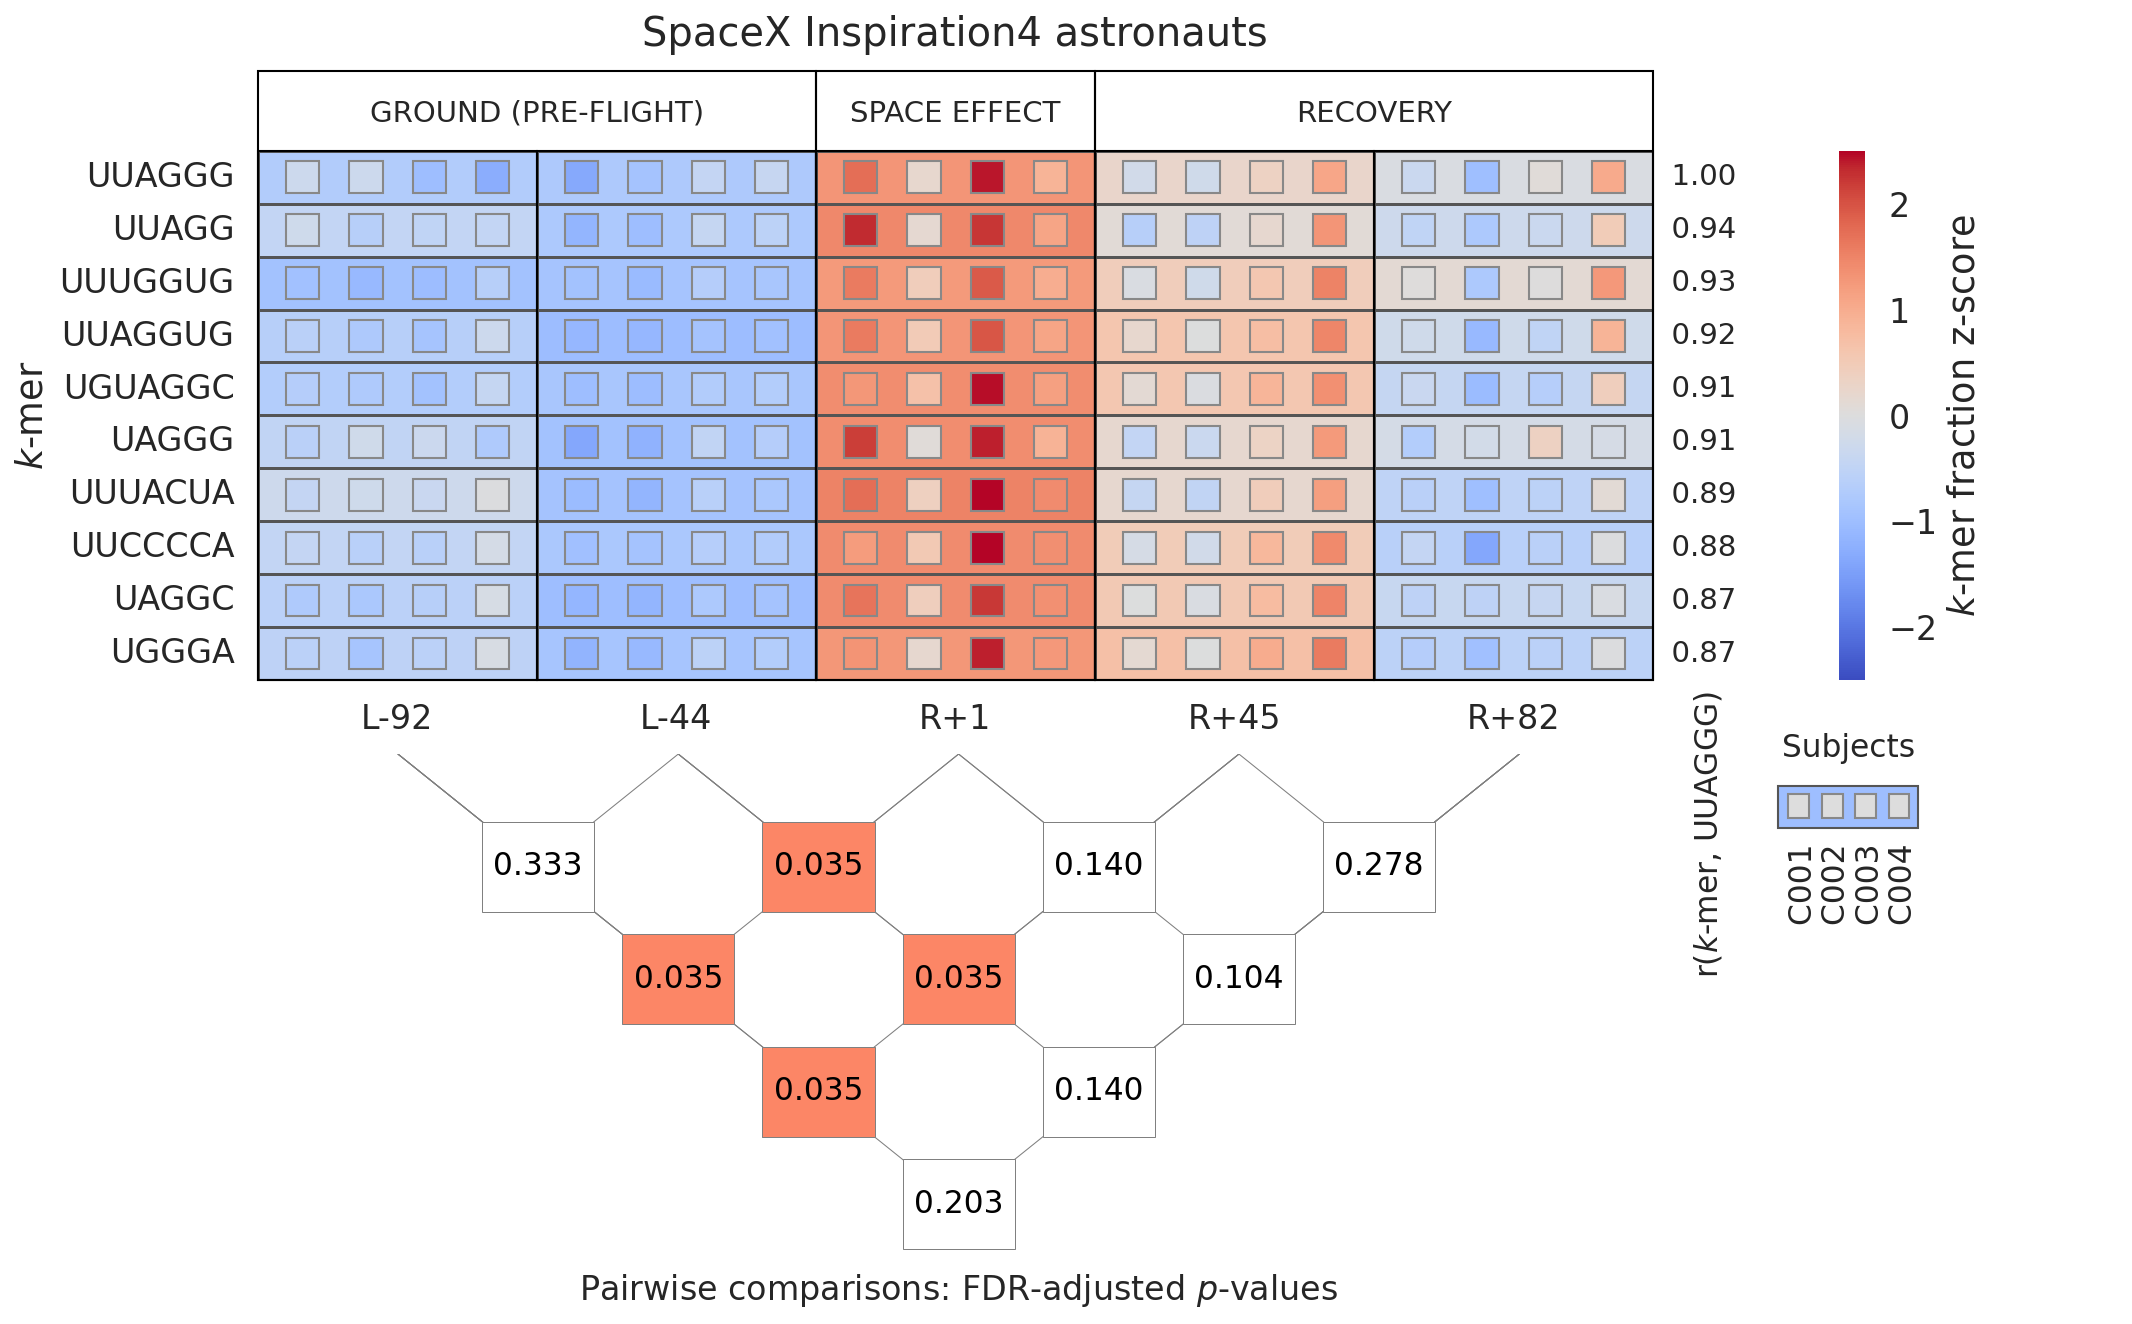

In [13]:
from matplotlib.colors import Normalize, PowerNorm
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Rectangle

def plot_zfractions(zmelted, sdf, kmers=KMERS):
    okmers = ["UUAGGG", *(kmer for kmer in kmers if kmer != "UUAGGG")]
    med = zmelted[["kmer", "timepoint", "fraction"]].groupby(["kmer", "timepoint"], as_index=False).mean().pivot(
        index="kmer", columns="timepoint", values="fraction",
    )
    med = med[ANALYSIS_TIMEPOINTS]
    med = med.reindex(KMERS)
    bysubj = []
    for subject in "C001", "C002", "C003", "C004":
        df = zmelted[zmelted["subject"]==subject].pivot(index="kmer", columns="timepoint", values="fraction")
        df = df[ANALYSIS_TIMEPOINTS]
        bysubj.append(pd.concat(axis=0, objs=[df.loc[[kmer]] for kmer in okmers]))
    f, axs = subplots(
        figsize=(16, 10), nrows=2,
        gridspec_kw=dict(hspace=.14, height_ratios=(1, 1)), dpi=150,
    )
    sns.heatmap(
        data=med.reindex(KMERS),
        ax=axs[0], vmin=-2.5, vmax=2.5, cmap="coolwarm", lw=.5, linecolor="#555", cbar_kws=dict(
        label="$k$-mer fraction z-score\n", location="right", aspect=20, pad=.1,
    ))
    scm = ScalarMappable(cmap="coolwarm", norm=Normalize(vmin=-2.5, vmax=2.5))
    for dx, df in enumerate(bysubj):
        for x, _ in enumerate(med.columns):
            for y, _ in enumerate(med.index):
                axs[0].add_patch(Rectangle((.1+x+dx/4.4, .2+y), .12, .6, fc=scm.to_rgba(df.iloc[y, x]), ec="#888", lw=1))
    axs[0].set(xlabel=None, ylabel="$k$-mer")
    #...
    scm_p = ScalarMappable(cmap="Reds_r", norm=PowerNorm(.5, vmin=0, vmax=.1))
    axs[1].invert_yaxis()
    for a in range(5):
        for b in range(5):
            if a < b:
                mx, my = (a+b)/2, abs(a-b)
                axs[1].plot([a, mx], [0, my], color="gray", lw=.5, zorder=1)
                axs[1].plot([b, mx], [0, my], color="gray", lw=.5, zorder=1)
                v = sdf.loc[ANALYSIS_TIMEPOINTS[b], ANALYSIS_TIMEPOINTS[a]]
                axs[1].add_patch(Rectangle(
                    (mx-.2, my-.4), .4, .8,
                    fc=(scm_p.to_rgba(v) if (v < .05) else "white"),
                    ec="gray", zorder=2,
                ))
                axs[1].text(s=f"{v:.3f}", x=mx, y=my, ha="center", va="center", size=15, color="black")
    axs[1].set(xlim=(-.5, 6.135), ylim=(4.7, 0), frame_on=False, xticks=[], yticks=[])
    axs[1].grid(False)
    #...
    axs[0].add_patch(Rectangle((0, -1.5), 2, 11.5, fc="none", ec="black", lw=1, clip_on=False))
    axs[0].add_patch(Rectangle((2, -1.5), 1, 11.5, fc="none", ec="black", lw=1, clip_on=False))
    axs[0].add_patch(Rectangle((3, -1.5), 2, 11.5, fc="none", ec="black", lw=1, clip_on=False))
    axs[0].text(s="GROUND (PRE-FLIGHT)", x=1.0, y=-.7, size=14, ha="center", va="center")
    axs[0].text(s="SPACE EFFECT", x=2.5, y=-.7, size=14, ha="center", va="center")
    axs[0].text(s="RECOVERY", x=4.0, y=-.7, size=14, ha="center", va="center")
    for x in range(5):
        axs[0].add_patch(Rectangle((x, 0), 1, 10, fc="none", ec="black", lw=1, clip_on=False))
    #...
    x, y = 5.45, 12
    axs[0].text(s="Subjects", x=x+.25, y=y-1, size=15, va="top", ha="center")
    axs[0].add_patch(Rectangle((x, y), .5, .8, fc=scm.to_rgba(-1), ec="#555", lw=1, clip_on=False))
    for dx in range(4):
        _x, _y = .035+x+dx*.12, .15+y
        axs[0].add_patch(Rectangle((_x, _y), .075, .45, fc="#DDD", ec="#888", lw=1, clip_on=False))
        axs[0].text(s=f"C00{dx+1} ", x=_x+.055, y=_y+.75, ha="center", va="top", size=15, rotation=90)
    axs[1].text(
        #s="Differences in raw $k$-mer fractions between each two time points:\nFDR-adjusted Mann-Whitney U p-values",
        s="Pairwise comparisons: FDR-adjusted $p$-values",
        x=2, y=4.6, size=16, ha="center", va="top",
    )
    axs[0].set(title="SpaceX Inspiration4 astronauts\n\n")
    for y, r in enumerate(datacorr["UUAGGG"].sort_values(ascending=False)[:10]):
        axs[0].text(s=f"  {r:.2f}", x=5, y=y+.5, size=14, ha="left", va="center")
    axs[0].text(s="r($k$-mer, UUAGGG)", x=5.2, y=10.2, ha="center", va="top", rotation=90, size=15)
    return f, axs

f, _ = plot_zfractions(zmelted, sdf)
# f.savefig("i4-motifs.pdf", bbox_inches="tight", dpi=300)